In [1]:
%load_ext autoreload
%autoreload 2

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [400]:
from synthetic_data import generate_cqr_data, indicator_matrix
from gcc import _get_kernel_matrix

In [387]:
# generate data
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(seed=123)

# fit a fourth order polynomial
poly = PolynomialFeatures(4)
reg = LinearRegression().fit(poly.fit_transform(x_train_final), y_train_final)

# score function is residual
score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))
score_inv_fn_ub = lambda s, x : [-np.inf, reg.predict(poly.fit_transform(x)) + s]
score_inv_fn_lb = lambda s, x : [reg.predict(poly.fit_transform(x)) + s, np.inf]

# coverage on indicators of all sub-intervals with endpoints in [0,0.5,1,..,5]
eps = 0.5
disc = np.arange(0, 5 + eps, eps)

def phi_fn(x):
    disc = 0.5
    return indicator_matrix(x, np.arange(0,5 + disc,disc))

In [ ]:
# sanity check with quantile regression fit to calibration data
import cvxpy as cp

eta = cp.Variable(shape=len(x_calib))

phi_calib = np.ones((x_calib.shape[0], 1))
scores_calib = score_fn(x_calib, y_calib)
scores_test = score_fn(x_test, y_test)

kernel = 'rbf'
gamma = 1
radius = 100  

_, L = _get_kernel_matrix(x_calib, kernel, gamma)

# C = radius / (n_calib + 1)

constraints = [
    (0.95 - 1) <= eta,
    0.95 >= eta,
    eta.T @ phi_calib == 0]
prob = cp.Problem(
            cp.Minimize(0.5 * cp.sum_squares(L.T @ eta) - cp.sum(cp.multiply(eta, cp.vec(scores_calib)))),
            constraints
        )
prob.solve(solver=cp.MOSEK)

rkhs_weights = eta.value
intercept = prob.constraints[-1].dual_value
K = pairwise_kernels(
    X=x_calib,
    metric=kernel,
    gamma=gamma
)
threshold = K @ rkhs_weights + intercept

plt.plot(x_calib, y_calib, '.', alpha=0.2)
plt.plot(x_calib, reg.predict(poly.fit_transform(x_calib)) + threshold, '.')

constraints = [
    C * (0.05 - 1) <= eta,
    C * 0.05 >= eta,
    eta.T @ phi_calib == 0]
prob = cp.Problem(
            cp.Minimize(0.5 * cp.sum_squares(L.T @ eta) - cp.sum(cp.multiply(eta, cp.vec(scores_calib)))),
            constraints
        )
prob.solve(solver=cp.MOSEK)

rkhs_weights = eta.value
intercept = prob.constraints[-1].dual_value
K = pairwise_kernels(
    X=x_calib,
    metric=kernel,
    gamma=gamma
)
threshold = K @ rkhs_weights + intercept
plt.plot(x_calib, reg.predict(poly.fit_transform(x_calib)) + threshold, '.')
# constraints = [
#     (0.05 - 1) <= eta,
#     0.05 >= eta,
#     eta.T @ phi_calib == 0
# ]
# prob = cp.Problem(
#     cp.Minimize(-1 * cp.sum(cp.multiply(eta, cp.vec(scores_calib)))),
#     constraints
# )
# prob.solve(solver=cp.MOSEK)

# beta_lower = prob.constraints[-1].dual_value

# sanity check coverage
# upper_baseline = phi_fn(x_test) @ beta_upper
# lower_baseline = phi_fn(x_test) @ beta_lower

# coverage = ((upper_baseline >= scores_test) & (lower_baseline <= scores_test)).flatten()
# ind12 = ((x_test <= 2) & (x_test >= 1)).flatten()
# ind34 = ((x_test <= 4) & (x_test >= 3)).flatten()

# print("marginal", np.mean(coverage))
# print("[1,2]", np.mean(coverage[ind12]))
# print("[3,4]", np.mean(coverage[ind34]))

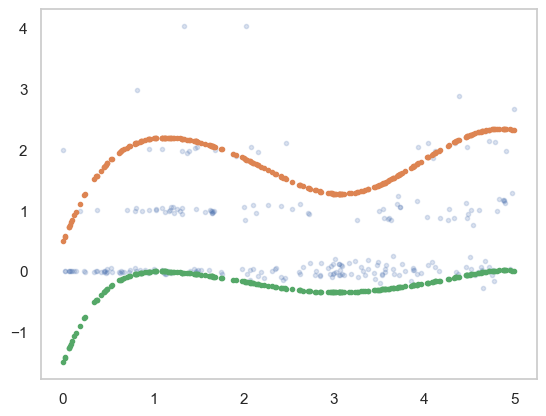

In [411]:
# sanity check with quantile regression fit to calibration data
import cvxpy as cp

eta = cp.Variable(shape=len(x_calib))

phi_calib = np.ones((x_calib.shape[0], 1))
scores_calib = score_fn(x_calib, y_calib)
scores_test = score_fn(x_test, y_test)

kernel = 'rbf'
gamma = 1
radius = 100  

_, L = _get_kernel_matrix(x_calib, kernel, gamma)

C = radius / (n_calib + 1)

constraints = [
    C * (0.95 - 1) <= eta,
    C * 0.95 >= eta,
    eta.T @ phi_calib == 0]
prob = cp.Problem(
            cp.Minimize(0.5 * cp.sum_squares(L.T @ eta) - cp.sum(cp.multiply(eta, cp.vec(scores_calib)))),
            constraints
        )
prob.solve(solver=cp.MOSEK)

rkhs_weights = eta.value
intercept = prob.constraints[-1].dual_value
K = pairwise_kernels(
    X=x_calib,
    metric=kernel,
    gamma=gamma
)
threshold = K @ rkhs_weights + intercept

plt.plot(x_calib, y_calib, '.', alpha=0.2)
plt.plot(x_calib, reg.predict(poly.fit_transform(x_calib)) + threshold, '.')

constraints = [
    C * (0.05 - 1) <= eta,
    C * 0.05 >= eta,
    eta.T @ phi_calib == 0]
prob = cp.Problem(
            cp.Minimize(0.5 * cp.sum_squares(L.T @ eta) - cp.sum(cp.multiply(eta, cp.vec(scores_calib)))),
            constraints
        )
prob.solve(solver=cp.MOSEK)

rkhs_weights = eta.value
intercept = prob.constraints[-1].dual_value
K = pairwise_kernels(
    X=x_calib,
    metric=kernel,
    gamma=gamma
)
threshold = K @ rkhs_weights + intercept
plt.plot(x_calib, reg.predict(poly.fit_transform(x_calib)) + threshold, '.')
# constraints = [
#     (0.05 - 1) <= eta,
#     0.05 >= eta,
#     eta.T @ phi_calib == 0
# ]
# prob = cp.Problem(
#     cp.Minimize(-1 * cp.sum(cp.multiply(eta, cp.vec(scores_calib)))),
#     constraints
# )
# prob.solve(solver=cp.MOSEK)

# beta_lower = prob.constraints[-1].dual_value

# sanity check coverage
# upper_baseline = phi_fn(x_test) @ beta_upper
# lower_baseline = phi_fn(x_test) @ beta_lower

# coverage = ((upper_baseline >= scores_test) & (lower_baseline <= scores_test)).flatten()
# ind12 = ((x_test <= 2) & (x_test >= 1)).flatten()
# ind34 = ((x_test <= 4) & (x_test >= 3)).flatten()

# print("marginal", np.mean(coverage))
# print("[1,2]", np.mean(coverage[ind12]))
# print("[3,4]", np.mean(coverage[ind34]))

In [ ]:
from gcc import GCC
from tqdm import tqdm

    x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(seed=seed)

    # fit a fourth order polynomial
    poly = PolynomialFeatures(4)
    reg = LinearRegression().fit(poly.fit_transform(x_train_final), y_train_final)

    # score function is residual
    score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))
    score_inv_fn_ub = lambda s, x : [-np.inf, reg.predict(poly.fit_transform(x)) + s]
    score_inv_fn_lb = lambda s, x : [reg.predict(poly.fit_transform(x)) + s, np.inf]

    # coverage on indicators of all sub-intervals with endpoints in [0,0.5,1,..,5]
    eps = 0.5
    disc = np.arange(0, 5 + eps, eps)

    def phi_fn(x):
        disc = 0.5
        return indicator_matrix(x, np.arange(0, 5 + disc, disc))
    alpha = 0.1

    cond_conf_ub = GCC(score_fn, phi_fn)
    cond_conf_ub.set_function_class(1 - alpha/2, x_calib, y_calib, infinite_params = {})

    cond_conf_lb = GCC(score_fn, phi_fn)
    cond_conf_lb.set_function_class(alpha/2, x_calib, y_calib, infinite_params = {})

    n_test = 500

    lbs = np.zeros((n_test,))
    ubs = np.zeros((n_test,))
    i = 0
    
    x_test = x_test[0:n_test]
    y_test = y_test[0:n_test]


    for x_t in x_test:
        res = cond_conf_lb.predict(x_t, score_inv_fn_lb)
        lbs[i] = res[0]
        res = cond_conf_ub.predict(x_t, score_inv_fn_ub)
        ubs[i] = res[1]
        i += 1
        
    q = np.quantile(np.abs(reg.predict(poly.fit_transform(x_calib)) - y_calib),
                    np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)
    scores_test = np.abs(y_test - reg.predict(poly.fit_transform(x_test)))

    cov_split = scores_test > q
    cov_test = np.logical_or(y_test > ubs, y_test < lbs)
    
    i_12 = ((x_test >= 1) & (x_test <= 2)).flatten()
    i_34 = ((x_test >= 3) & (x_test <= 4)).flatten()
    
    cov_marg = [np.mean(cov_split), np.mean(cov_test)]
    cov_12 = [np.mean(cov_split[i_12]), np.mean(cov_test[i_12])]
    cov_34 = [np.mean(cov_split[i_34]), np.mean(cov_test[i_34])]

In [399]:
from gcc import GCC
from tqdm import tqdm


def run_trial(seed):
    x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(seed=seed)

    # fit a fourth order polynomial
    poly = PolynomialFeatures(4)
    reg = LinearRegression().fit(poly.fit_transform(x_train_final), y_train_final)

    # score function is residual
    score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))
    score_inv_fn_ub = lambda s, x : [-np.inf, reg.predict(poly.fit_transform(x)) + s]
    score_inv_fn_lb = lambda s, x : [reg.predict(poly.fit_transform(x)) + s, np.inf]

    # coverage on indicators of all sub-intervals with endpoints in [0,0.5,1,..,5]
    eps = 0.5
    disc = np.arange(0, 5 + eps, eps)

    def phi_fn(x):
        disc = 0.5
        return indicator_matrix(x, np.arange(0, 5 + disc, disc))
    alpha = 0.1

    cond_conf_ub = GCC(score_fn, phi_fn)
    cond_conf_ub.set_function_class(1 - alpha/2, x_calib, y_calib, infinite_params = {})

    cond_conf_lb = GCC(score_fn, phi_fn)
    cond_conf_lb.set_function_class(alpha/2, x_calib, y_calib, infinite_params = {})

    n_test = 500

    lbs = np.zeros((n_test,))
    ubs = np.zeros((n_test,))
    i = 0
    
    x_test = x_test[0:n_test]
    y_test = y_test[0:n_test]


    for x_t in x_test:
        res = cond_conf_lb.predict(x_t, score_inv_fn_lb)
        lbs[i] = res[0]
        res = cond_conf_ub.predict(x_t, score_inv_fn_ub)
        ubs[i] = res[1]
        i += 1
        
    q = np.quantile(np.abs(reg.predict(poly.fit_transform(x_calib)) - y_calib),
                    np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)
    scores_test = np.abs(y_test - reg.predict(poly.fit_transform(x_test)))

    cov_split = scores_test > q
    cov_test = np.logical_or(y_test > ubs, y_test < lbs)
    
    i_12 = ((x_test >= 1) & (x_test <= 2)).flatten()
    i_34 = ((x_test >= 3) & (x_test <= 4)).flatten()
    
    cov_marg = [np.mean(cov_split), np.mean(cov_test)]
    cov_12 = [np.mean(cov_split[i_12]), np.mean(cov_test[i_12])]
    cov_34 = [np.mean(cov_split[i_34]), np.mean(cov_test[i_34])]
    return cov_marg, cov_12, cov_34


m = []
one = []
two = []
for trial in tqdm(range(1)):
    marginal, g1, g2 = run_trial(seed=trial)
    m.append(marginal)
    one.append(g1)
    two.append(g2)

print(np.mean(m, axis=0), np.mean(one, axis=0), np.mean(two, axis=0))

import pickle

with open('group_results.pkl', 'wb') as fp:
    pickle.dump((m, one, two), fp)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [04:08<00:00, 248.75s/it]

[0.124 0.13 ] [0.18518519 0.17592593] [0.04444444 0.05555556]


array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [591]:
from gcc import GCC
from tqdm import tqdm
from scipy.stats import norm
from synthetic_data import generate_cqr_data

seed = 1
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(seed=seed)

# fit a fourth order polynomial
poly = PolynomialFeatures(4)
reg = LinearRegression().fit(poly.fit_transform(x_train_final), y_train_final)

# score function is residual
score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))
score_inv_fn_ub = lambda s, x : [-np.inf, reg.predict(poly.fit_transform(x)) + s]
score_inv_fn_lb = lambda s, x : [reg.predict(poly.fit_transform(x)) + s, np.inf]

# coverage on indicators of all sub-intervals with endpoints in [0,0.5,1,..,5]
eps = 0.5
disc = np.arange(0, 5 + eps, eps)

def phi_fn(x):
    return indicator_matrix(x, disc)

# coverage on two Gaussians
loc_1 = 1.5
loc_2 = 3.5
loc_3 = 0.5
loc_4 = 2.5
loc_5 = 4.5
scale = 0.2

def phi_fn(x):
    return np.concatenate([np.ones((x.shape[0],1)), 
                           norm.pdf(x, loc=loc_1, scale=scale).reshape(-1,1), 
                           norm.pdf(x, loc=loc_2, scale=scale).reshape(-1,1),
                           norm.pdf(x, loc=loc_3, scale=1).reshape(-1,1),
                           norm.pdf(x, loc=loc_4, scale=1).reshape(-1,1),
                           norm.pdf(x, loc=loc_5, scale=1).reshape(-1,1)],
                         axis=1)
alpha = 0.1

cond_conf_ub = GCC(score_fn, phi_fn)
cond_conf_ub.set_function_class(1 - alpha/2, x_calib, y_calib, infinite_params = {})

cond_conf_lb = GCC(score_fn, phi_fn)
cond_conf_lb.set_function_class(alpha/2, x_calib, y_calib, infinite_params = {})

n_test = 500

lbs = np.zeros((n_test,))
ubs = np.zeros((n_test,))
i = 0

x_test = x_test[0:n_test]
y_test = y_test[0:n_test]


for x_t in tqdm(x_test):
    res = cond_conf_lb.predict(x_t, score_inv_fn_lb)
    lbs[i] = res[0]
    res = cond_conf_ub.predict(x_t, score_inv_fn_ub)
    ubs[i] = res[1]
    i += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:35<00:00,  1.49it/s]


In [584]:
cov_test = np.logical_and(y_test <= ubs, y_test >= lbs)

scores_test = np.abs(y_test - reg.predict(poly.fit_transform(x_test)))
Phi_test = Phi_fn(x_test)

q = np.quantile(np.abs(reg.predict(poly.fit_transform(x_calib)) - y_calib),
                np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)

import pickle
with open('shift_results.pkl', 'rb') as fp:
    results = pickle.load(fp)
    
marginal_cov = results[0]
coverageData = pd.DataFrame({'Method': ['Split'] * len(marginal_cov), 
                             'Range' : ['Marginal'] * len(marginal_cov), 
                             'Miscoverage': np.asarray(marginal_cov)[:,0]})

coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': ['Conditional'] * len(marginal_cov), 
                               'Range' : ['Marginal'] * len(marginal_cov), 
                               'Miscoverage': np.asarray(marginal_cov)[:,1]
                              }
                          )],
                         axis=0)
                          
cov_1 = results[1]
cov1_name = '$f_1$'
# cov1_name = '[1,2]'
coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': ['Split'] * len(cov_1), 
                               'Range' : [cov1_name] * len(cov_1), 
                               'Miscoverage': np.asarray(cov_1)[:,0]
                              }
                          )], 
                         axis=0)

coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': ['Conditional'] * len(cov_1), 
                               'Range' : [cov1_name] * len(cov_1), 
                               'Miscoverage': np.asarray(cov_1)[:,1]
                              }
                          )], axis=0)
                          
cov_2 = results[2]
cov2_name = '$f_2$'
# cov2_name = '[3,4]'
coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': ['Split'] * len(cov_2), 
                               'Range' : [cov2_name] * len(cov_2), 
                               'Miscoverage': np.asarray(cov_2)[:,0]
                              }
                          )], axis=0)

coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': ['Conditional'] * len(cov_2), 
                               'Range' : [cov2_name] * len(cov_2), 
                               'Miscoverage': np.asarray(cov_2)[:,1]
                              }
                          )], axis=0)

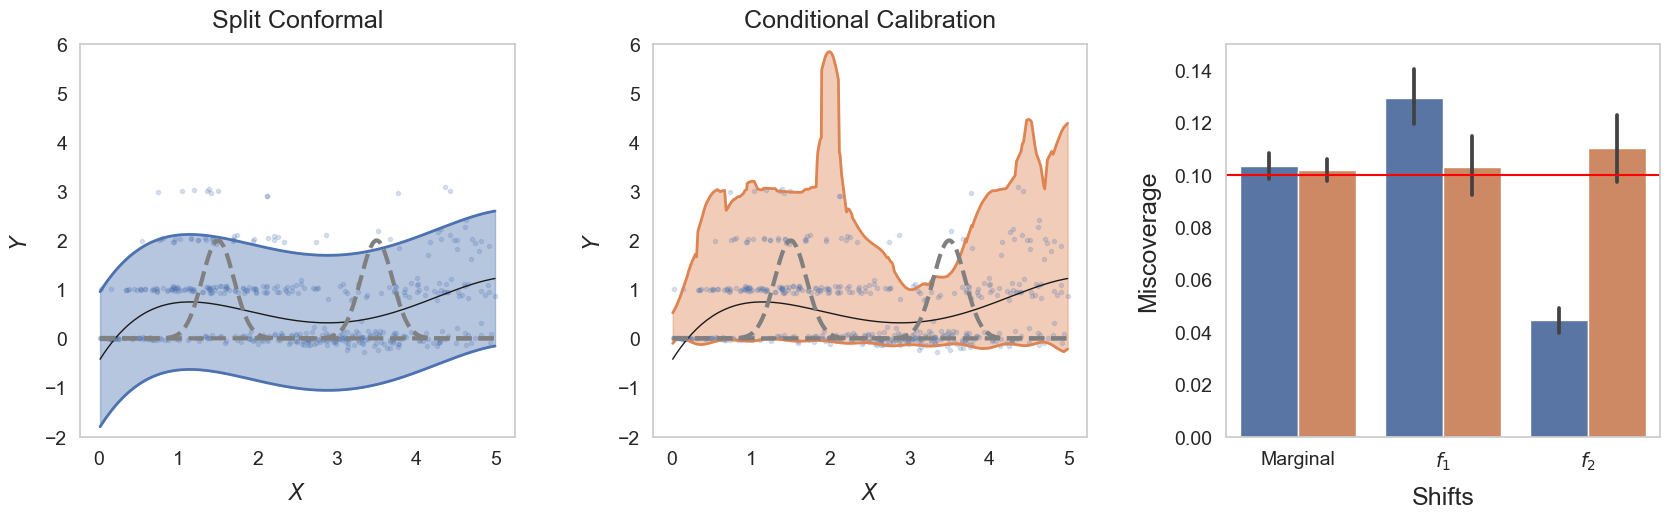

In [592]:
#fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(17.5, 6)

sort_order = np.argsort(x_test[0:n_test,0])
x_test_s = x_test[sort_order]
y_test_s = y_test[sort_order]
y_test_hat = reg.predict(poly.fit_transform(x_test[sort_order]))
lb = lbs[sort_order]
ub = ubs[sort_order]


ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax1.plot(x_test_s, y_test_hat, lw=1, color='k')
ax1.plot(x_test_s, y_test_hat + q, color=cp[0], lw=2)
ax1.plot(x_test_s, y_test_hat - q, color=cp[0], lw=2)
ax1.fill_between(x_test_s.flatten(), y_test_hat - q, y_test_hat + q, 
                 color=cp[0], alpha=0.4, label='split prediction interval')
ax1.set_ylim(-2,6)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Split Conformal", fontsize=18, pad=12)

# ax1.axvspan(1, 2, facecolor='grey', alpha=0.25)
# ax1.axvspan(3, 4, facecolor='grey', alpha=0.25)
ax1.plot(x_test_s, norm.pdf(x_test_s, loc=loc_1, scale=scale), color='grey', ls='--', lw=3)
ax1.plot(x_test_s, norm.pdf(x_test_s, loc=loc_2, scale=scale), color='grey', ls='--', lw=3)

ax2 = fig.add_subplot(1, 3, 2, sharex = ax1, sharey = ax1)
ax2.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax2.plot(x_test_s, y_test_hat, color='k', lw=1)
ax2.plot(x_test_s, ub, color=cp[1], lw=2)
ax2.plot(x_test_s, lb, color=cp[1], lw=2)
ax2.fill_between(x_test_s.flatten(), lb, 
                 ub, 
                 color=cp[1], alpha=0.4, label='conditional calibration')
ax2.tick_params(axis='both', which='major', direction='out', labelsize=14)
ax2.set_xlabel("$X$", fontsize=16, labelpad=10)
ax2.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax2.set_title("Conditional Calibration", fontsize=18, pad=12)


ax2.plot(x_test_s, norm.pdf(x_test_s, loc=loc_1, scale=scale), color='grey', ls='--', lw=3)
ax2.plot(x_test_s, norm.pdf(x_test_s, loc=loc_2, scale=scale), color='grey', ls='--', lw=3)
# ax2.axvspan(1, 2, facecolor='grey', alpha=0.25)
# ax2.axvspan(3, 4, facecolor='grey', alpha=0.25)

ax3 = fig.add_subplot(1, 3, 3)
f = sns.barplot(
    coverageData, 
    x='Range', 
    y='Miscoverage',
    hue='Method',
    palette=cp,
    ax = ax3
)
f.axhline(0.1, color='red')
f.legend_.remove()
ax3.set_ylabel("Miscoverage", fontsize=18, labelpad=10)
ax3.set_xlabel("Shifts", fontsize=18, labelpad=10)
ax3.set_ylim(0.,0.15)
ax3.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout(pad=3)

# plt.savefig('cqrDataComparison_shifts.pdf')

In [520]:
from gcc import GCC
from tqdm import tqdm
from scipy.stats import norm
from synthetic_data import generate_cqr_data

seed = 1
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(seed=seed)

# fit a fourth order polynomial
poly = PolynomialFeatures(4)
reg = LinearRegression().fit(poly.fit_transform(x_train_final), y_train_final)

# score function is residual
score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))
score_inv_fn_ub = lambda s, x : [-np.inf, reg.predict(poly.fit_transform(x)) + s]
score_inv_fn_lb = lambda s, x : [reg.predict(poly.fit_transform(x)) + s, np.inf]

def phi_fn(x):
    return np.ones((x.shape[0], 1))
alpha = 0.1
infinite_params = {'kernel': 'rbf', 'gamma': 12.5, 'lambda': 0.005}


cond_conf_ub = GCC(score_fn, phi_fn)
cond_conf_ub.set_function_class(1 - alpha/2, x_calib, y_calib, infinite_params)

cond_conf_lb = GCC(score_fn, phi_fn)
cond_conf_lb.set_function_class(alpha/2, x_calib, y_calib, infinite_params)

n_test = 500

lbs = np.zeros((n_test,))
ubs = np.zeros((n_test,))
i = 0

x_test = x_test[0:n_test]
y_test = y_test[0:n_test]


for x_t in tqdm(x_test):
    res = cond_conf_lb.predict(x_t, score_inv_fn_lb)
    lbs[i] = res[0]
    res = cond_conf_ub.predict(x_t, score_inv_fn_ub)
    ubs[i] = res[1]
    i += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:12:51<00:00,  8.74s/it]


In [577]:
def obtain_estimates(seed):
    x_train_2, y_train_2, x_calib_2, y_calib_2, x_test_2, y_test_2 = generate_cqr_data(seed=seed)

    # fit a fourth order polynomial
    poly = PolynomialFeatures(4)
    reg = LinearRegression().fit(poly.fit_transform(x_train_2), y_train_2)

    # score function is residual
    score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))
    score_inv_fn_ub = lambda s, x : [-np.inf, reg.predict(poly.fit_transform(x)) + s]
    score_inv_fn_lb = lambda s, x : [reg.predict(poly.fit_transform(x)) + s, np.inf]

    def phi_fn(x):
        return np.ones((x.shape[0], 1))
    alpha = 0.1
    infinite_params = {'kernel': 'rbf', 'gamma': 12.5, 'lambda': 0.005}


    gcc_ub = GCC(score_fn, phi_fn)
    gcc_ub.set_function_class(1 - alpha/2, x_calib_2, y_calib_2, infinite_params)

    gcc_lb = GCC(score_fn, phi_fn)
    gcc_lb.set_function_class(alpha/2, x_calib_2, y_calib_2, infinite_params)

    w_1 = np.zeros((len(x_calib), 1))
    ind = np.argsort(np.abs(x_calib_2.flatten() - 1.5))[0]
    w_1[ind] = 1

    w_2 = np.zeros((len(x_calib), 1))
    ind = np.argsort(np.abs(x_calib_2.flatten() - 3.5))[0]
    w_2[ind] = 1
    miscover_ub_1 = 1 - gcc_ub.estimate_coverage(1 - alpha/2, w_1)[0]
    miscover_ub_2 = 1 - gcc_ub.estimate_coverage(1 - alpha/2, w_2)[0]

    miscover_lb_1 = gcc_lb.estimate_coverage(alpha/2, w_1)[0]
    miscover_lb_2 = gcc_lb.estimate_coverage(alpha/2, w_1)[0]
    return miscover_ub_1 + miscover_lb_1, miscover_ub_2 + miscover_lb_2

estimates_1 = []
estimates_2 = []
for seed in tqdm(range(1, 21)):
    est_1, est_2 = obtain_estimates(seed)
    estimates_1.append(est_1)
    estimates_2.append(est_2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


In [578]:
cov_test = np.logical_and(y_test <= ubs, y_test >= lbs)

scores_test = np.abs(y_test - reg.predict(poly.fit_transform(x_test)))
Phi_test = Phi_fn(x_test)

q = np.quantile(np.abs(reg.predict(poly.fit_transform(x_calib)) - y_calib),
                np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)

import pickle
with open('agnostic_results.pkl', 'rb') as fp:
    results = pickle.load(fp)
                          
cov_1 = results[1]
cov1_name = '$f_1$'
coverageData = pd.DataFrame({'Method': ['Split'] * len(marginal_cov), 
                             'Range' : [cov1_name] * len(cov_1), 
                             'Miscoverage': estimates_1})

coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': ['Conditional'] * len(cov_1), 
                               'Range' : [cov1_name] * len(cov_1), 
                               'Miscoverage': np.asarray(cov_1)[:,1]
                              }
                          )], axis=0)
                          
cov_2 = results[2]
cov2_name = '$f_2$'
# cov2_name = '[3,4]'
coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': ['Split'] * len(cov_2), 
                               'Range' : [cov2_name] * len(cov_2), 
                               'Miscoverage': estimates_2
                              }
                          )], axis=0)

coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': ['Conditional'] * len(cov_2), 
                               'Range' : [cov2_name] * len(cov_2), 
                               'Miscoverage': np.asarray(cov_2)[:,1]
                              }
                          )], axis=0)

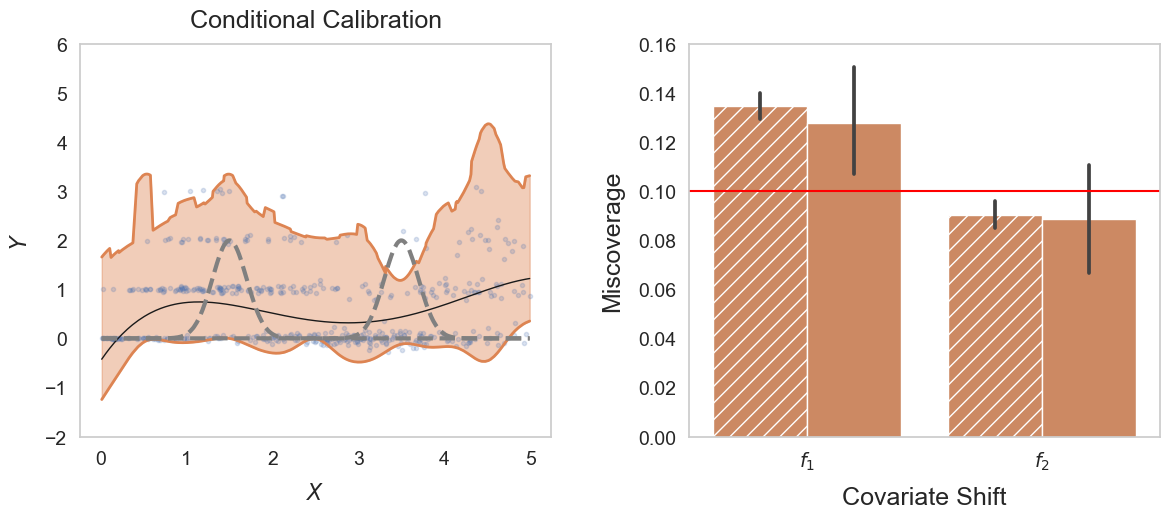

In [580]:
#fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(12.5, 6)

sort_order = np.argsort(x_test[0:n_test,0])
x_test_s = x_test[sort_order]
y_test_s = y_test[sort_order]
y_test_hat = reg.predict(poly.fit_transform(x_test[sort_order]))
lb_ag = lbs[sort_order]
ub_ag = ubs[sort_order]

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax1.plot(x_test_s, y_test_hat, lw=1, color='k')
ax1.plot(x_test_s, ub_ag, color=cp[1], lw=2)
ax1.plot(x_test_s, lb_ag, color=cp[1], lw=2)
ax1.fill_between(x_test_s.flatten(), lb_ag, ub_ag, 
                 color=cp[1], alpha=0.4, label='split prediction interval')
ax1.set_ylim(-2,6)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Conditional Calibration", fontsize=18, pad=12)

# ax1.axvspan(1, 2, facecolor='grey', alpha=0.25)
# ax1.axvspan(3, 4, facecolor='grey', alpha=0.25)
ax1.plot(x_test_s, norm.pdf(x_test_s, loc=loc_1, scale=scale), color='grey', ls='--', lw=3)
ax1.plot(x_test_s, norm.pdf(x_test_s, loc=loc_2, scale=scale), color='grey', ls='--', lw=3)

ax2 = fig.add_subplot(1, 2, 2)

f = sns.barplot(
    coverageData, 
    x='Range', 
    y='Miscoverage',
    hue='Method',
    palette=cp,
    ax = ax2
)
orange = f.patches[2].get_facecolor()
f.patches[0].set_hatch('//')
f.patches[0].set_facecolor(orange)
f.patches[1].set_hatch('//')
f.patches[1].set_facecolor(orange)

plt.draw()
f.axhline(0.1, color='red')
f.legend_.remove()
# plt.legend(fontsize=18)
ax2.set_ylabel("Miscoverage", fontsize=18, labelpad=10)
ax2.set_xlabel("Covariate Shift", fontsize=18, labelpad=10)
ax2.set_ylim(0.,0.16)
ax2.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout(pad=3)

plt.savefig('cqrDataComparison_agnostic.pdf')